# Computer Vision | Homework 07 
### Mohsen Ebadpour | 400131080 | m.ebadpour@aut.ac.ir

In [1]:
import numpy as np 
import open3d as o3d
import matplotlib.pyplot as plt
import cv2 
import scipy
import pandas as pd


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Part A | Visualize a sample cloud points

In [2]:
base_bin_path = "./kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/velodyne_points/data/000000000{0}.bin"
base_rgb_path = "./kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_02/data/000000000{0}.jpg"

for I in range(4): 
    data = np.fromfile(base_bin_path.format(I), dtype=np.float32)
    data = data.reshape((-1,4))
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(data[:, 0:3])
    o3d.visualization.draw_geometries([pcd], width=800, height=600, window_name='Open3D')
    o3d.io.write_point_cloud('./sample_{0}.pcd'.format(I), pcd)

### Part B | Map cloud points to image

#### Read matrices

In [3]:
calib_path = "./kitti_sample/2011_09_29/calib_cam_to_cam.txt"
velo2cam_path = "./kitti_sample/2011_09_29/calib_velo_to_cam.txt"

def read_calib_file(path):
    with open(path, 'r') as f:
        for line in f.readlines():
            if line.startswith('R_rect_00:'):
                R_rect_00 = np.array(line[11:].split(' '), dtype=np.float32)
                R_rect_00 = R_rect_00.reshape((3, 3))
            elif line.startswith('P_rect_02:'):
                P_rect_02 = np.array(line[11:].split(' '), dtype=np.float32)
                P_rect_02 = P_rect_02.reshape((3, 4))
                
    return R_rect_00, P_rect_02


def read_velo2cam_file(path):
    with open(path, 'r') as f:
        for line in f.readlines():
            if line.startswith('R:'):
                R_velo_tocam = np.array(line[3:].split(' '), dtype=np.float32)
                R_velo_tocam = R_velo_tocam.reshape((3, 3))
            elif line.startswith('T:'):
                T_velo_to_cam = np.array(line[3:].split(' '), dtype=np.float32)
                T_velo_to_cam = T_velo_to_cam.reshape((3, 1))

    return R_velo_tocam, T_velo_to_cam


#### Create Projection Matrix

In [4]:
def create_projection_matrix(R_velo_tocam, T_velo_to_cam, R_rect_00, P_rect_02):
    P_velo2cam = np.zeros((4, 4))
    P_velo2cam[0:3, 0:3] = R_velo_tocam
    P_velo2cam[0:3, 3] = T_velo_to_cam.reshape((3))
    P_velo2cam[3, 3] = 1
    
    R_ref2rect = np.zeros((4, 4))
    R_ref2rect[0:3, 0:3] = R_rect_00

    P_rect2cam = P_rect_02
    
    P  = P_rect2cam @ R_ref2rect @ P_velo2cam
    return P

In [5]:
R_rect_00, P_rect_02 = read_calib_file(calib_path)
R_velo_tocam, T_velo_to_cam = read_velo2cam_file(velo2cam_path)
P = create_projection_matrix(R_velo_tocam, T_velo_to_cam, R_rect_00, P_rect_02)


#### Convert lidar points to camera`s image plane

In [6]:
def lidar_to_image(points, projection_matrix):
    points = np.vstack((points[0:3,:], np.ones((1, points.shape[1]))))
    image_points = np.dot(projection_matrix, points)
    image_points[0, :] = image_points[0, :] / image_points[2, :]
    image_points[1, :] = image_points[1, :] / image_points[2, :]
    image_points = image_points[0:2, :]
    depth = points[0, :]

    return image_points,depth


#### Process and plot depth

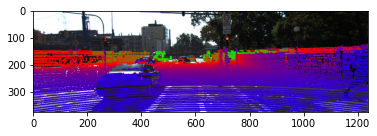

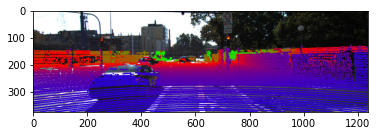

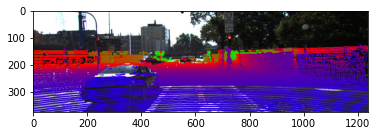

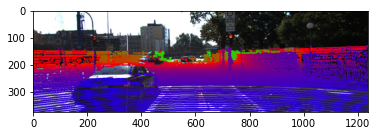

In [7]:
def preprocess_3d_point(img_3d_data,img_rgb,show=False):
    img_rgb = img_rgb.copy()
    h, w, _ = img_rgb.shape
    # remove points behind/blind the camera
    img_3d_data = img_3d_data[(img_3d_data['x'] >= 0) & (img_3d_data['x'] < w) & (img_3d_data['y'] >= 0) & (img_3d_data['y'] < h)]
    
    # remove points behind the camera
    img_3d_data = img_3d_data[(img_3d_data['z'] >= 0)]

    # normalize depth
    img_3d_data['z'] /= img_3d_data['z'].max()
    img_3d_data = img_3d_data.sort_values(by=['z'])

    # create color map for depth
    cmap = plt.cm.get_cmap('brg', 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

    # create color for each point
    img_3d_data['color'] = img_3d_data['z'].apply(lambda x: cmap[int(255 * x) , :])

    # draw points on image
    for i in range(img_3d_data.shape[0]):
        cv2.circle(img_rgb, (int(img_3d_data.iloc[i]['x']), int(img_3d_data.iloc[i]['y'])), 1, color=(tuple(img_3d_data.iloc[i]['color'])), thickness=2)
    
    if show:
        plt.imshow(img_rgb)
        plt.show()

    return img_3d_data,img_rgb
    

img_3d_list = []
img_rgb_list = []
for I in range(4): 
    data = np.fromfile(base_bin_path.format(I), dtype=np.float32)
    data = data.reshape((-1,4))

    img = cv2.imread(base_rgb_path.format(I))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_points, depth = lidar_to_image(data.T, P)

    img_3d_data = pd.DataFrame({'x': image_points[0, :], 'y': image_points[1, :], 'z': depth})

    img_3d_data,img_rgb = preprocess_3d_point(img_3d_data,img,show=True)
    img_3d_list.append(img_3d_data)
    img_rgb_list.append(img_rgb)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite('project_cloud_to_img_{}.png'.format(I),img_bgr)


    

### Part C | Interpolation cloud points

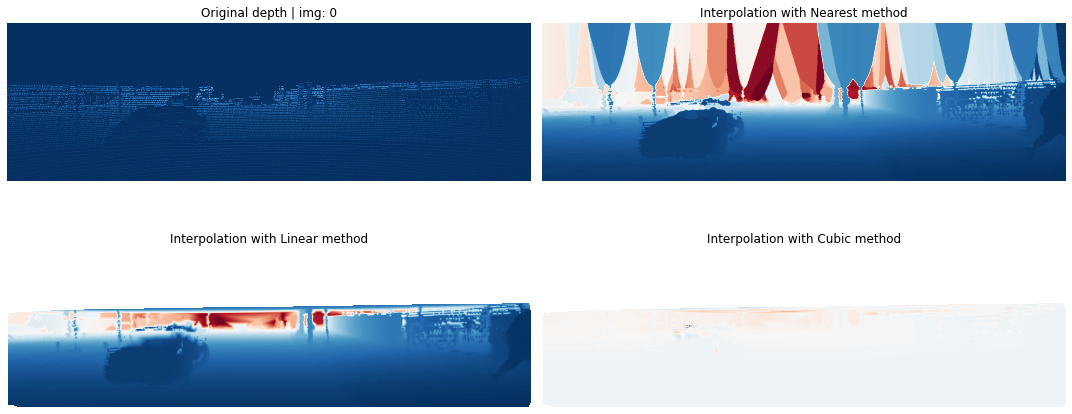

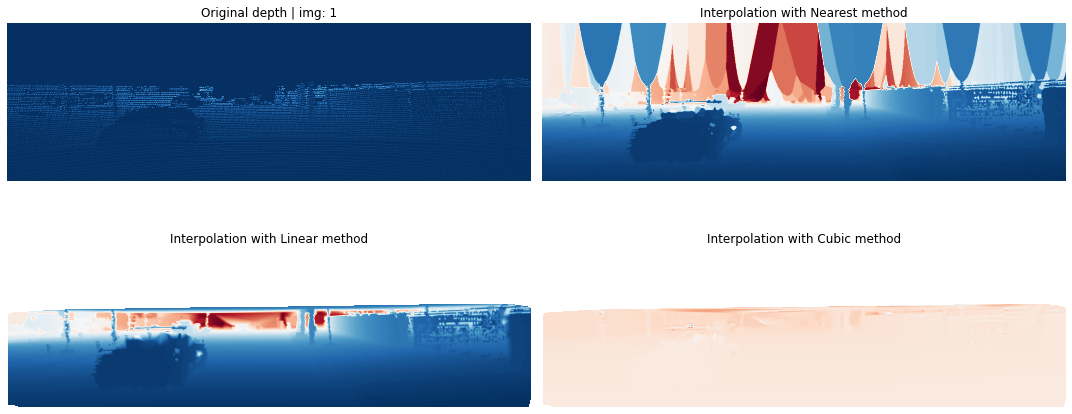

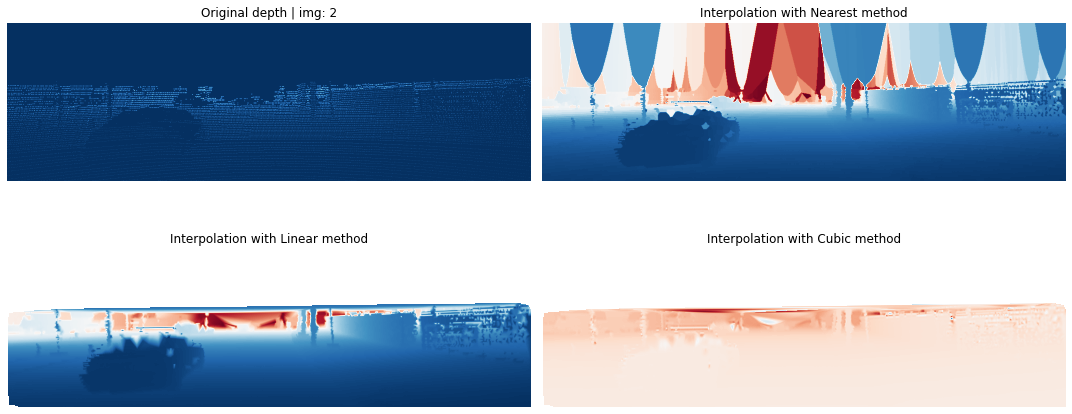

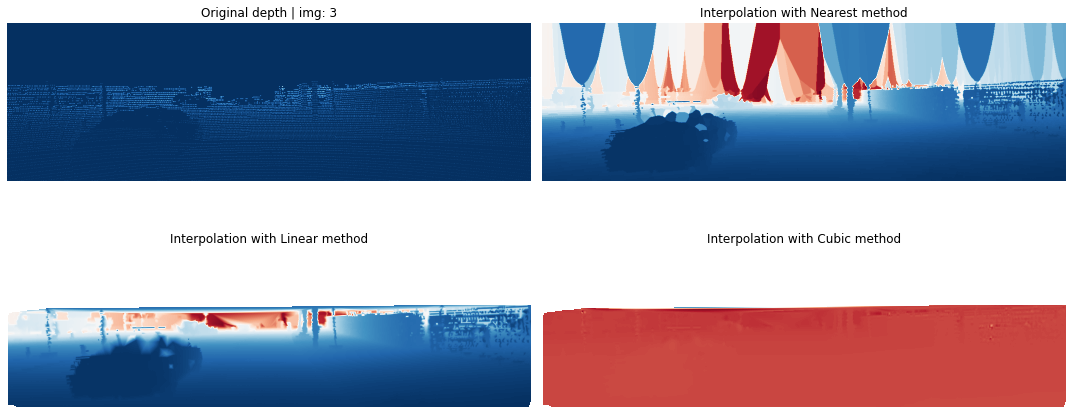

In [8]:
def interpolation_cloud_points(img_3d_data,img_rgb,_id,show=False):
    h, w, _ = img_rgb.shape
    x = np.arange(0, w, 1)
    y = np.arange(0, h, 1)
    x, y = np.meshgrid(x, y)

    # interpolate depth
    inters = []

    depth = np.zeros((h, w))
    for i in range(img_3d_data.shape[0]):
        depth[int(img_3d_data.iloc[i]['y']), int(img_3d_data.iloc[i]['x'])] = img_3d_data.iloc[i]['z']

    inters.append(depth)

    for methd in ['nearest', 'linear', 'cubic']:
        depth = scipy.interpolate.griddata((img_3d_data['x'], img_3d_data['y']), img_3d_data['z'], (x, y), method=methd)
        inters.append(depth)

    if show:
        labels = ['Original depth | img: {0}'.format(_id), 'Interpolation with Nearest method', 'Interpolation with Linear method', 'Interpolation with Cubic method']
        plt.figure(figsize=(15, 7))
        for i in range(len(inters)):
            plt.subplot(2, 2, i + 1)
            #tmp = ((inters[i] - inters[i].min()) / (inters[i].max()- inters[i].min()) )*255
            plt.imshow(inters[i],cmap='RdBu_r')
            plt.title(labels[i])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    return inters 

inters_3d_list = []
for I in range(4):
    inters = interpolation_cloud_points(img_3d_list[I],img_rgb_list[I],I,show=True)
    inters_3d_list.append(inters)
    


### Part D | Stereo depth estimation

In [9]:
def disparity_to_depth(disparity, baseline=0.53715, focal_length=721.537):
    depth = (baseline * focal_length) / (disparity + 1e-4)
    depth_rgb = ((depth - depth.min()) / (depth.max()- depth.min()) )*255
    depth_bgr = cv2.cvtColor(depth_rgb.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    cv2.imwrite('depth.png',depth_bgr)
    return depth

def depth_to_3d(depth):
    h, w = depth.shape
    x = np.arange(0, w, 1)
    y = np.arange(0, h, 1)
    x, y = np.meshgrid(x, y)
    x = x.reshape(-1)
    y = y.reshape(-1)
    z = depth.reshape(-1)
    points = np.vstack((x, y, z)).T

    points = points[points[:, 2] > 0]
    points = points[points[:, 2] < 120]

    points[:,2] = points[:,2] / points[:,2].max() * 255
    #points = points.astype(np.uint8)
    return points

left_img = cv2.imread("./kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_00/data/0000000002.jpg", 0)
right_img = cv2.imread("./kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_01/data/0000000002.jpg", 0)
stereo = cv2.StereoBM_create(numDisparities=0, blockSize=15)
disparity = stereo.compute(left_img,right_img)

disparity_rgb = ((disparity - disparity.min()) / (disparity.max()- disparity.min()) )*255

disparity_bgr = cv2.cvtColor(disparity_rgb.astype(np.uint8), cv2.COLOR_GRAY2BGR)
cv2.imwrite('disparity.png',disparity_bgr)

depth = disparity_to_depth(disparity)
points = depth_to_3d(depth)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([pcd])


### Part E | Reconstruction

In [11]:
for I in range(4):
    img = cv2.imread("./project_cloud_to_img_{0}.png".format(I))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(img),
        o3d.geometry.Image(inters_3d_list[I][1].astype(np.float32)),
        depth_scale=1.0,
        depth_trunc=50.0,
        convert_rgb_to_intensity=False)
    

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

    o3d.visualization.draw_geometries([pcd],width=1600, height=1200, window_name='Open3D')
